# Dynamic breakpoints 

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback. 

## Goals

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

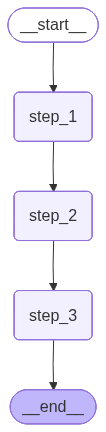

In [2]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [3]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)}


C:\Users\palle\AppData\Local\Temp\ipykernel_23756\4174644561.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [4]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

In [5]:
print(state.tasks)

(PregelTask(id='0f4f3b1d-dbbd-e30d-d91d-820643b1d162', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [6]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)}


C:\Users\palle\AppData\Local\Temp\ipykernel_23756\4174644561.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [7]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [8]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3584-b83a-62ef-8002-31bac782764a'}}

In [9]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}
